In [1]:
# import statements including namaster python wrapper
import numpy as np
import healpy as hp
import os
import pymaster as nmt
import pysm3
import pysm3.units as u
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# matplotlib formatting
rc('text', usetex=True)
res_dpi = 300
ext = 'pdf'

In [3]:
# read in a planck mask, lower resolution, and apodize it on a scale of ~3 degrees
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 5 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 5)
# read planck mask (GAL070) and lower resolution to nside=128
mask = hp.read_map("HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=3)
mask_128 = hp.pixelfunc.ud_grade(mask, 128, dtype=float)
#hp.mollview(mask_128, title='Mask at Nside 128')
# save mask
hp.write_map("mask_GAL070_128.fits", mask_128, dtype=float, overwrite=True)
# read mask and apodize it on a scale of ~3degs
mask = nmt.mask_apodization(hp.read_map("mask_GAL070_128.fits", verbose=False), 3., apotype="Smooth")
#hp.mollview(mask, title='Apodized mask')

In [4]:
ell_arr = b.get_effective_ells()
print(ell_arr)

[  4.   9.  14.  19.  24.  29.  34.  39.  44.  49.  54.  59.  64.  69.
  74.  79.  84.  89.  94.  99. 104. 109. 114. 119. 124. 129. 134. 139.
 144. 149. 154. 159. 164. 169. 174. 179. 184. 189. 194. 199. 204. 209.
 214. 219. 224. 229. 234. 239. 244. 249. 254. 259. 264. 269. 274. 279.
 284. 289. 294. 299. 304. 309. 314. 319. 324. 329. 334. 339. 344. 349.
 354. 359. 364. 369. 374. 379.]


In [5]:
def compute_rl(map_217GHz, map_353GHz):
    # initialize a spin-2 field for BB, compute cl values
    f2_217 = nmt.NmtField(mask, map_217GHz[1:,:], purify_b = True)
    f2_353 = nmt.NmtField(mask, map_353GHz[1:,:], purify_b = True)
    clbb217x217 = nmt.compute_full_master(f2_217, f2_217, b)[3]
    clbb217x353 = nmt.compute_full_master(f2_217, f2_353, b)[3]
    clbb353x353 = nmt.compute_full_master(f2_353, f2_353, b)[3]
    rl_vals = clbb217x353/(np.sqrt(clbb217x217*clbb353x353))
    return rl_vals

In [6]:
# make skies for d1, d10, d12 models
sky_1 = pysm3.Sky(nside=128, preset_strings=["d1"])
sky_10 = pysm3.Sky(nside=128, preset_strings=["d10"])
sky_12 = pysm3.Sky(nside=128, preset_strings=["d12"])
# make 217GHz and 353GHz maps for each model
map_217GHz_1 = sky_1.get_emission(217 * u.GHz)
map_353GHz_1 = sky_1.get_emission(353 * u.GHz)
map_217GHz_10 = sky_10.get_emission(217 * u.GHz)
map_353GHz_10 = sky_10.get_emission(353 * u.GHz)
map_217GHz_12 = sky_12.get_emission(217 * u.GHz)
map_353GHz_12 = sky_12.get_emission(353 * u.GHz)
# compute rl values
rl_vals_1 = compute_rl(map_217GHz_1, map_353GHz_1)
rl_vals_10 = compute_rl(map_217GHz_10, map_353GHz_10)
rl_vals_12 = compute_rl(map_217GHz_12, map_353GHz_12)

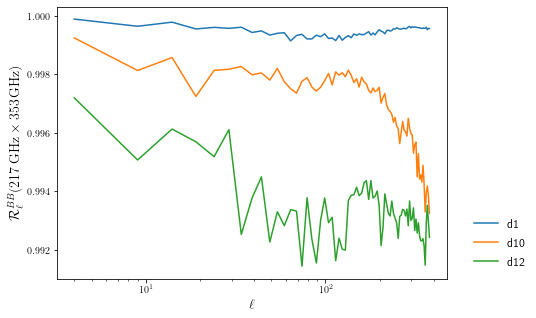

In [7]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$', fontsize=14)
ax.set_ylabel(r'$\mathcal{R}^{BB}_{\ell} (217\,{\rm GHz}\times353\,{\rm GHz})$', fontsize=14)

ax.plot(ell_arr, rl_vals_1, label= 'd1')
ax.plot(ell_arr, rl_vals_10, label= 'd10')
ax.plot(ell_arr, rl_vals_12, label= 'd12')

ax.legend(frameon=False, prop={'size': 12}, loc = 'lower left', bbox_to_anchor=(1.04,0))

plt.savefig('lvsrl.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')